In [214]:
pip install pandas_ta

In [215]:
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Data

In [216]:
# Stock Blackrock
stock_symbol = 'BLK'
start_date = '2021-01-01'
end_date = '2024-01-01'

# Fetch the data from Yahoo Finance
data = pd.read_csv('BLK.csv', index_col = 'Date', parse_dates = True)
stock_data = data.copy()

ind = data.index.to_list()
data['Date'] = pd.to_datetime(ind)

# Storing only necessary data
stock_data = stock_data[['Close']]
data = data[['Date', 'Close']]
data.index = range(len(data))

# Plots

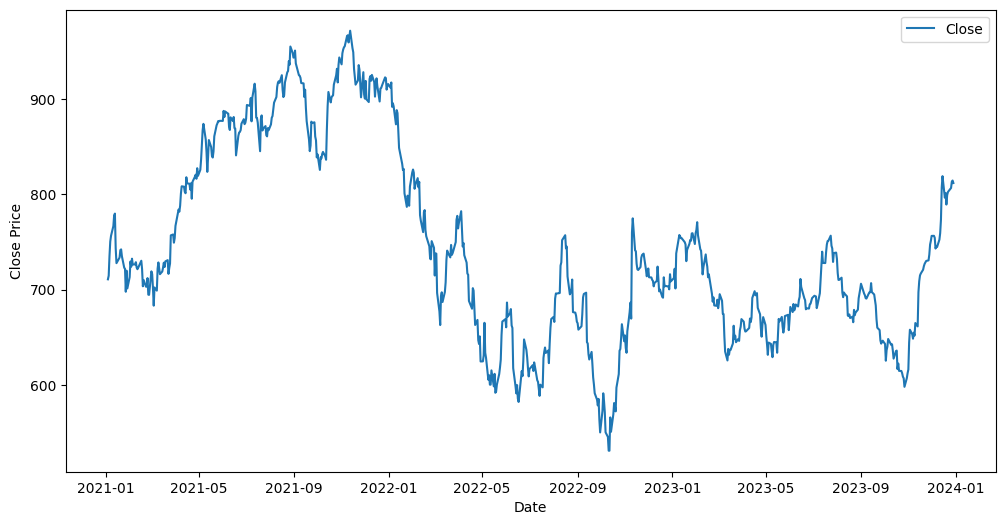

In [217]:
# Plots
fig, axes = plt.subplots(figsize = (12,6))
sns.lineplot(
    data = stock_data
)
plt.ylabel('Close Price')
plt.show()

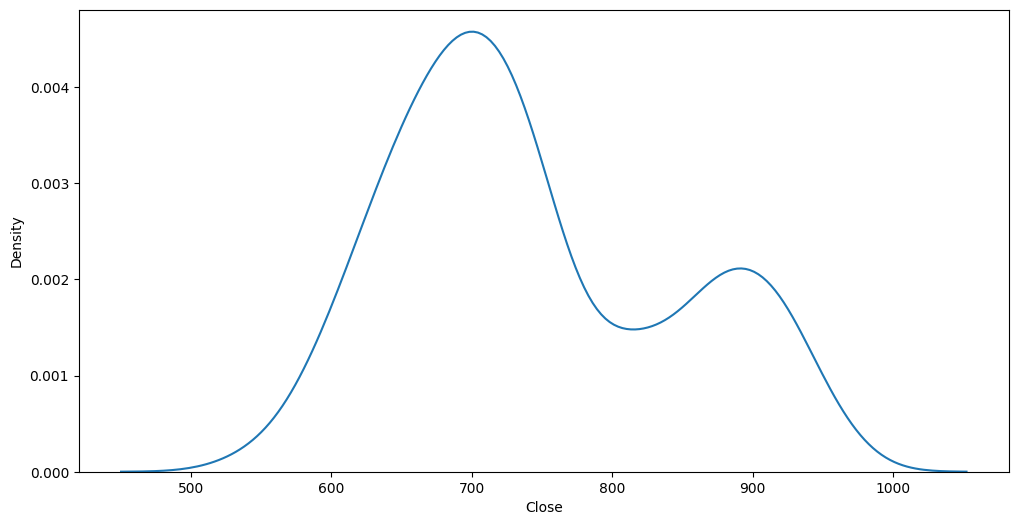

In [218]:
# Plots
fig, axes = plt.subplots(figsize = (12,6))
sns.kdeplot(
    data = data,
    x = 'Close'
)
plt.show()

# Prediction using technical indicators

In [219]:
# Actual Long or Short
data['Actual'] = [0]*len(data)
for i in range(1, len(data)):
    if data['Close'][i-1] < data['Close'][i]:
        data['Actual'][i] = 1
    elif data['Close'][i-1] > data['Close'][i]:
        data['Actual'][i] = -1
    else:
        data['Actual'][i] = 0

stock_data['Actual'] = list(data['Actual'])

In [220]:
# Moving Average (MA)
ma_period = 20
stock_data['MA'] = ta.sma(stock_data['Close'], length=ma_period)

# Relative Strength Index (RSI)
rsi_period = 14
stock_data['RSI'] = ta.rsi(stock_data['Close'], length=rsi_period)

# Bollinger's Bands (BB)
window_length = 5
std_dev_factor = 2.0

# Calculate rolling mean and standard deviation
stock_data['rolling_mean'] = stock_data['Close'].rolling(window=window_length).mean()
stock_data['upper_band'] = stock_data['rolling_mean'] + (std_dev_factor * stock_data['Close'].rolling(window=window_length).std())
stock_data['lower_band'] = stock_data['rolling_mean'] - (std_dev_factor * stock_data['Close'].rolling(window=window_length).std())

# MACD
short_term_period = 12
long_term_period = 26
signal_period = 9

# Calculate short-term and long-term EMAs
stock_data['Short_EMA'] = stock_data['Close'].ewm(span=short_term_period, adjust=False).mean()
stock_data['Long_EMA'] = stock_data['Close'].ewm(span=long_term_period, adjust=False).mean()

# Calculate MACD Line
stock_data['MACD_Line'] = stock_data['Short_EMA'] - stock_data['Long_EMA']

# Calculate Signal Line
stock_data['Signal_Line'] = stock_data['MACD_Line'].ewm(span=signal_period, adjust=False).mean()

# Calculate MACD Histogram
stock_data['MACD_Histogram'] = stock_data['MACD_Line'] - stock_data['Signal_Line']

indicators = stock_data[['Close', 'MA', 'RSI', 'rolling_mean', 'upper_band', 'lower_band', 'MACD_Line', 'Signal_Line']]



In [221]:
# All predictions
# MA
dataset = pd.DataFrame()
ma_pred = []
for i in range(len(stock_data)):
    if(stock_data['MA'][i] >= stock_data['Close'][i]):
        ma_pred.append(-1)
    else:
        ma_pred.append(1)
stock_data['MA_pred'] = ma_pred
dataset['MA_pred'] = stock_data['MA_pred']

# RSI
rsi_pred = []
for i in range(len(stock_data)):
    if(stock_data['RSI'][i] >= 50):
        rsi_pred.append(1)
    else:
        rsi_pred.append(-1)
stock_data['RSI_pred'] = rsi_pred

# BB
stock_data['BB_pred'] = 0  # Default to no BB_pred
stock_data['BB_pred'][stock_data['Close'] < stock_data['lower_band']] = 1  # Buy BB_pred (bullish)
stock_data['BB_pred'][stock_data['Close'] > stock_data['upper_band']] = -1  # Sell BB_pred (bearish)
for i in range(30, len(stock_data)):
    if stock_data['BB_pred'][i] == 0:
        if stock_data['rolling_mean'][i] < stock_data['Close'][i]:
            stock_data['BB_pred'][i] = 1
        else:
            stock_data['BB_pred'][i] = -1

# MACD
stock_data['MACD_pred'] = 0  # Default to no MACD_pred
stock_data['MACD_pred'][stock_data['Signal_Line'] < stock_data['MACD_Line']] = 1  # Buy MACD_pred (bullish)
stock_data['MACD_pred'][stock_data['Signal_Line'] > stock_data['MACD_Line']] = -1  # Sell BB_pred (bearish)


# Plots

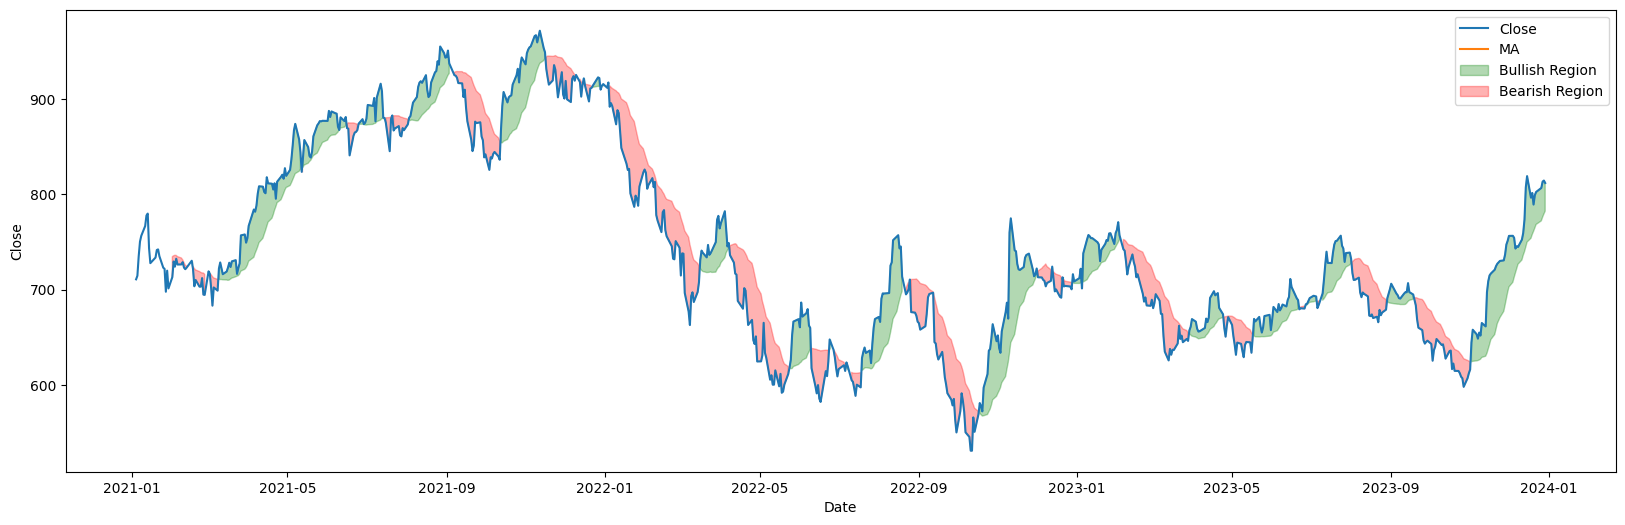

In [222]:
# Plots
fig, axes = plt.subplots(figsize = (20,6))
sns.lineplot(
    data=data,
    x='Date',
    y='Close',
    label='Close',
)

# Plot the MA line
sns.lineplot(
    data=stock_data,
    x=data['Date'],
    y='MA',
    label='MA',
)

# Fill between Close and MA lines for bullish (MA_pred == 1)
plt.fill_between(
    data['Date'],
    stock_data['Close'],
    stock_data['MA'],
    where=(stock_data['MA_pred'] == 1),
    color='green',
    alpha=0.3,
    label='Bullish Region',
)

# Fill between Close and MA lines for bearish (MA_pred == -1)
plt.fill_between(
    data['Date'],
    stock_data['Close'],
    stock_data['MA'],
    where=(stock_data['MA_pred'] == -1),
    color='red',
    alpha=0.3,
    label='Bearish Region',
)

plt.legend()
plt.show()

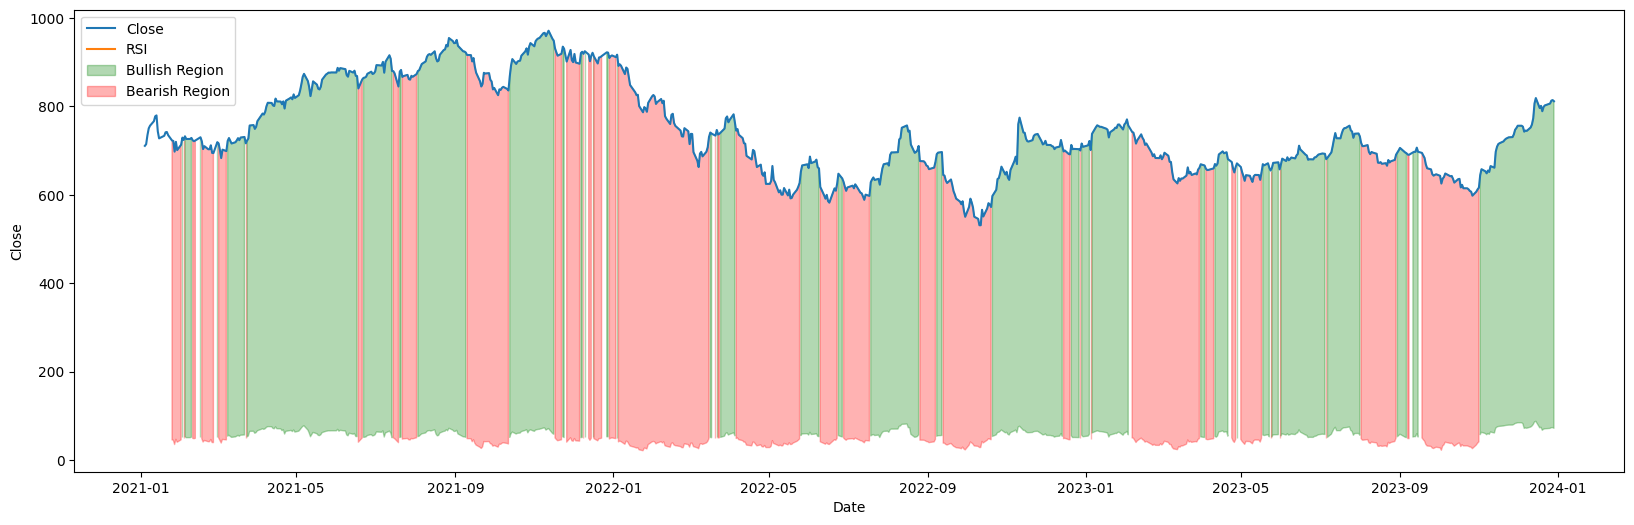

In [223]:
# Plots
fig, axes = plt.subplots(figsize = (20,6))
sns.lineplot(
    data=data,
    x='Date',
    y='Close',
    label='Close',
)

# Plot the RSI line
sns.lineplot(
    data=stock_data,
    x=data['Date'],
    y='RSI',
    label='RSI',
)

# Fill between Close and RSi lines for bullish (RSI_pred == 1)
plt.fill_between(
    data['Date'],
    stock_data['Close'],
    stock_data['RSI'],
    where=(stock_data['RSI_pred'] == 1),
    color='green',
    alpha=0.3,
    label='Bullish Region',
)

# Fill between Close and RSI lines for bearish (RSI_pred == -1)
plt.fill_between(
    data['Date'],
    stock_data['Close'],
    stock_data['RSI'],
    where=(stock_data['RSI_pred'] == -1),
    color='red',
    alpha=0.3,
    label='Bearish Region',
)

plt.legend()
plt.show()

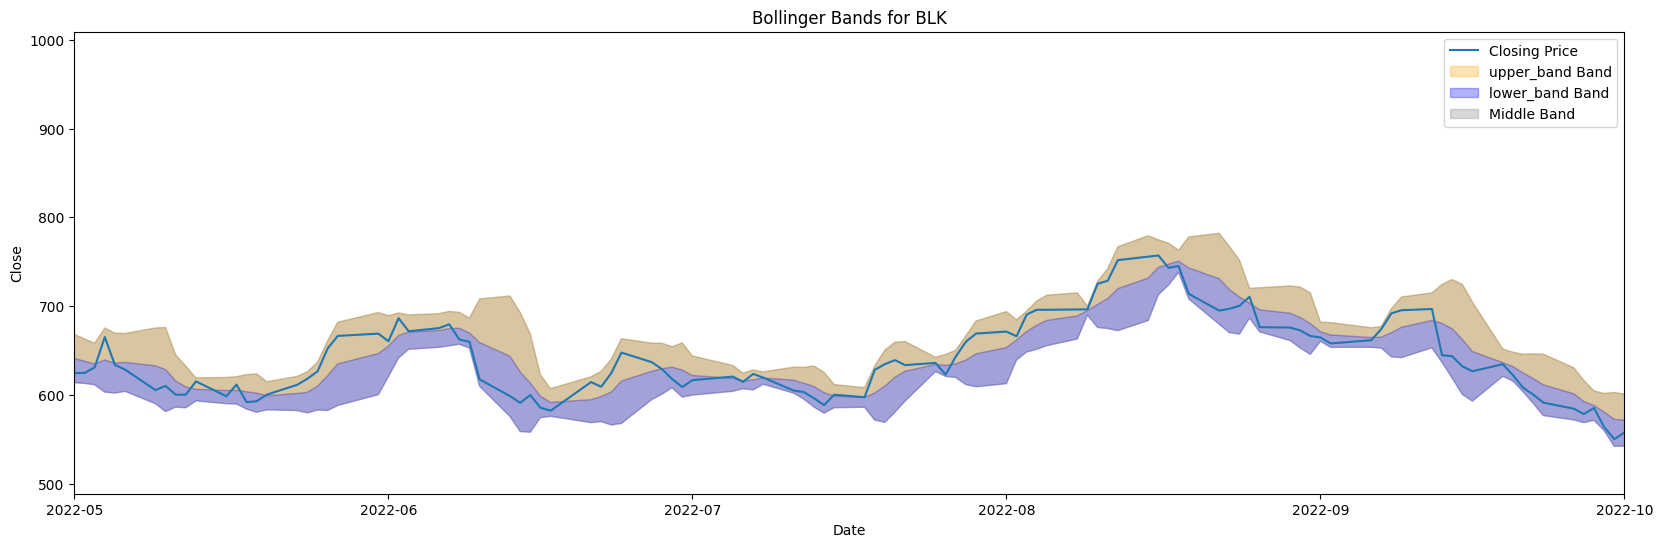

In [224]:
plt.figure(figsize = (20, 6))
sns.lineplot(data=data, x='Date', y='Close', label='Closing Price')
blk_data = pd.DataFrame()
blk_data['Close'] = stock_data['Close']
blk_data['Upper'] = stock_data['upper_band']
blk_data['Lower'] = stock_data['lower_band']
blk_data['MA'] = stock_data['MA']
blk_data['Bearish'] = ((blk_data['Close'] > blk_data['Upper']) | ((blk_data['MA'] < blk_data['Close']) & (blk_data['Close'] < blk_data['Lower'])))
blk_data['Bullish'] = ((blk_data['Close'] < blk_data['Lower']) | ((blk_data['Upper'] < blk_data['Close']) & (blk_data['Close'] < blk_data['MA'])))
# Plot Bollinger Bands
plt.fill_between(data['Date'], stock_data['upper_band'], stock_data['rolling_mean'], color='orange', alpha=0.3, label='upper_band Band')
plt.fill_between(data['Date'], stock_data['rolling_mean'], stock_data['lower_band'], color='blue', alpha=0.3, label='lower_band Band')
plt.fill_between(data['Date'], stock_data['upper_band'], stock_data['lower_band'], color='gray', alpha=0.3, label='Middle Band')

# Highlight Bearish and Bullish regions
plt.fill_between(data['Date'], stock_data['Close'], stock_data['upper_band'], where=blk_data['Bearish'], color='red', alpha=0.3)
plt.fill_between(data['Date'], stock_data['Close'], stock_data['lower_band'], where=blk_data['Bullish'], color='green', alpha=0.3)

plt.title(f"Bollinger Bands for {stock_symbol}")
plt.xlim(pd.to_datetime("2022-05-01"), pd.to_datetime("2022-10-01"))
plt.legend()
plt.show()

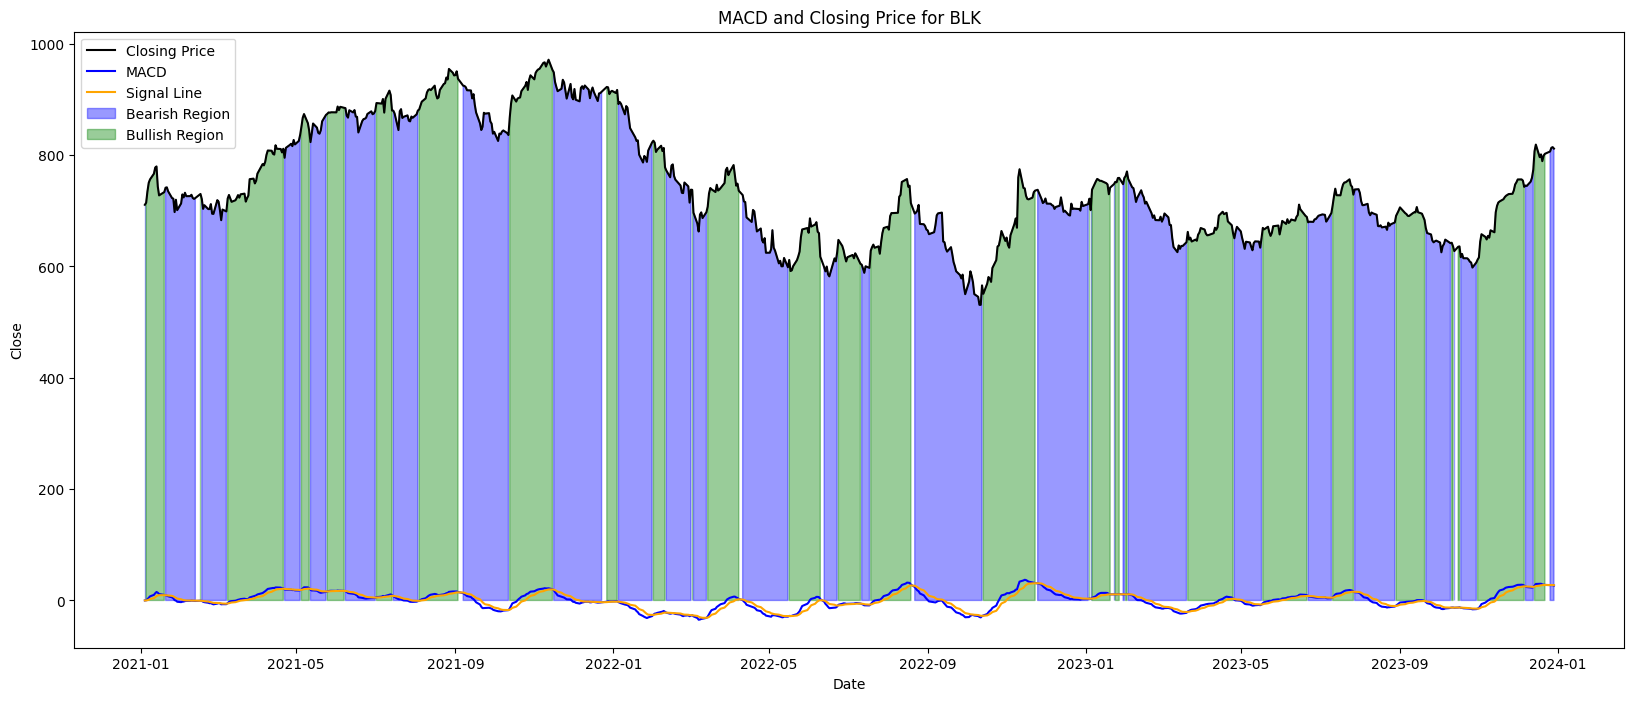

In [225]:
blk_data = stock_data.copy()

# Determine bullish and bearish regions based on MACD and Signal Line
blk_data['Bearish'] = blk_data['MACD_Line'] - blk_data['Signal_Line'] <= 0
blk_data['Bullish'] = blk_data['MACD_Line'] - blk_data['Signal_Line'] > 0

# Plots
fig, axes = plt.subplots(figsize=(20, 8))

# Plot Closing Price
sns.lineplot(data=blk_data, x='Date', y='Close', label='Closing Price', color='black')

# Plot MACD and Signal Line
sns.lineplot(data=blk_data, x='Date', y='MACD_Line', label='MACD', color='blue')
sns.lineplot(data=blk_data, x='Date', y='Signal_Line', label='Signal Line', color='orange')

# Fill regions below MACD line based on bullish and bearish predictions
plt.fill_between(data['Date'], 0, blk_data['Close'], where=blk_data['Bearish'], color='blue', alpha=0.4, label='Bearish Region')
plt.fill_between(data['Date'], 0, blk_data['Close'], where=blk_data['Bullish'], color='green', alpha=0.4, label='Bullish Region')


plt.title(f"MACD and Closing Price for {stock_symbol}")
plt.legend()
plt.show()


# Correlation analysis

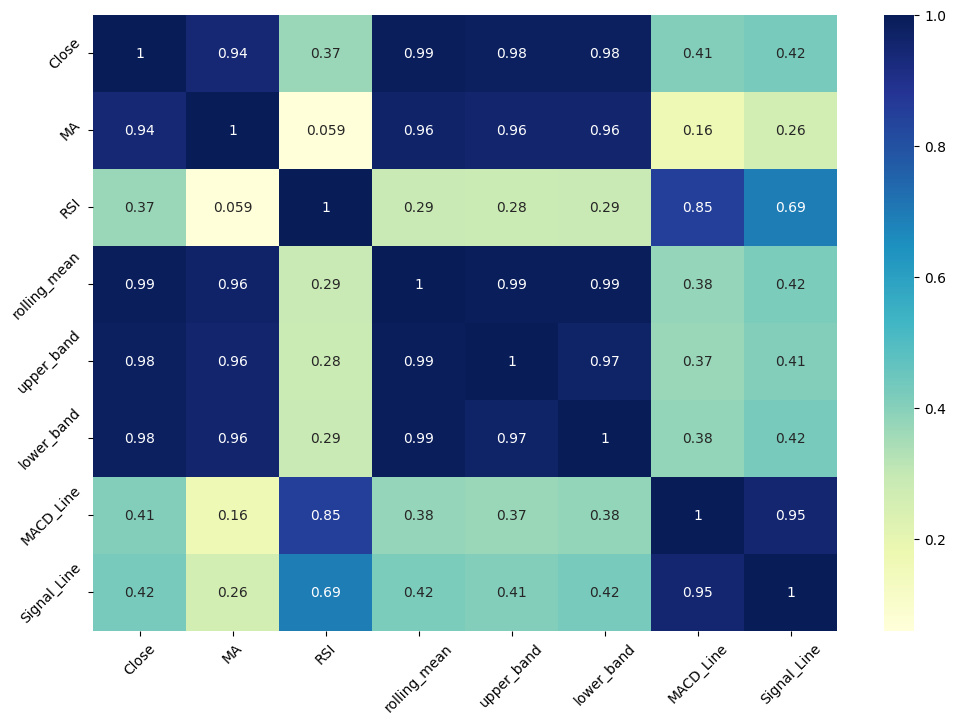

In [226]:
# Calculate the correlation matrix
corr1 = indicators.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr1, annot=True, cmap="YlGnBu")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Method-1: Combining weighted indicators prediction

In [227]:
# Combined
stock_data['Combined_pred'] = 0
for i in range(30, len(stock_data)):
    # Extract indicator values for the current row
    indicator_values = stock_data.iloc[i, [12,13,14,15]]
    weights = np.array([ 0.01 , 0.55, 0.23, 0.2])
    sum1 = sum(weights)

    ans = (
        weights[0]/sum1 * indicator_values['MA_pred'] +
        weights[1]/sum1 * indicator_values['BB_pred'] +
        weights[2]/sum1 * indicator_values['RSI_pred'] +
        weights[3]/sum1 * indicator_values['MACD_pred']
    )

    # threshold = 0
    # if ans >= threshold it is considered as bullish
    # else bearish
    if ans >= 0:
        stock_data['Combined_pred'][i] = 1
    else:
        stock_data['Combined_pred'][i] = -1

In [228]:
# Accuracy calculation
def accuracy(column):
    global stock_data
    acc = 0
    for i in range(30,len(stock_data)):
        if stock_data['Actual'][i] == stock_data[column][i]:
            acc+=1
    return acc/(len(stock_data)-30)

res = accuracy('Combined_pred')
print(f"Accuracy of prediction is {res * 100:.4f} %")

Accuracy of prediction is 77.1784 %


# Method-2: Normalizing and combining indicators

In [229]:
temp1 = (indicators - np.min(indicators, axis = 0))/(np.max(indicators, axis = 0) - np.min(indicators, axis = 0))
weights = np.array([ 0.01 , 0.23, 0.55, 0.2])
stock_data['Combined_value_mean'] = (
    weights[0] * temp1['MA'] +
    weights[1] * temp1['RSI'] +
    weights[2] * temp1['rolling_mean'] +
    weights[3] * temp1['MACD_Line']
)

stock_data['Combined_value_lower'] = (
    weights[0] * temp1['MA'] +
    weights[1] * temp1['RSI'] +
    weights[2] * temp1['lower_band'] +
    weights[3] * temp1['MACD_Line']
)

stock_data['Combined_value_upper'] = (
    weights[0] * temp1['MA'] +
    weights[1] * temp1['RSI'] +
    weights[2] * temp1['upper_band'] +
    weights[3] * temp1['MACD_Line']
)

stock_data['Combine_predic'] = 0
stock_data['Combine_predic'][stock_data['Combined_value_mean'] < stock_data['Combined_value_lower']] = 1
stock_data['Combine_predic'][stock_data['Combined_value_mean'] > stock_data['Combined_value_upper']] = -1
for i in range(30, len(stock_data)):
    if stock_data['Combine_predic'][i] == 0:
        if stock_data['Combined_value_mean'][i] < stock_data['Close'][i]:
            stock_data['Combine_predic'][i] = 1
        else:
            stock_data['Combine_predic'][i] = -1

In [230]:
res1 = accuracy('Combine_predic')
print(f"Accuracy of prediction is {res1 * 100:.4f} %")

Accuracy of prediction is 46.7497 %


# Method-3: Optimising MSE

In [231]:
data1 = pd.read_csv('BLK.csv', index_col = 'Date', parse_dates = True)
stock_data1 = data1.copy()

ind = data1.index.to_list()
data1['Date'] = pd.to_datetime(ind)

# Storing only necessary data1
data1.index = range(len(data1))

# Calculate Moving Average (MA)
ma_period = 20
stock_data1['MA'] = ta.sma(stock_data1['Close'], length=ma_period)

# Calculate Relative Strength Index (RSI)
rsi_period = 14
stock_data1['RSI'] = ta.rsi(stock_data1['Close'], length=rsi_period)

# Calculate On-Balance Volume (OBV)
stock_data1['OBV'] = ta.obv(stock_data1['Close'], stock_data1['Volume'])

# Calculate Average Directional Index (ADX)
adx_period = 14
adx_values = ta.adx(stock_data1['High'], stock_data1['Low'], stock_data1['Close'], length=adx_period)
stock_data1['ADX'] = adx_values['ADX_' + str(adx_period)]


indicators = stock_data1[['Close', 'MA', 'RSI', 'OBV', 'ADX']]

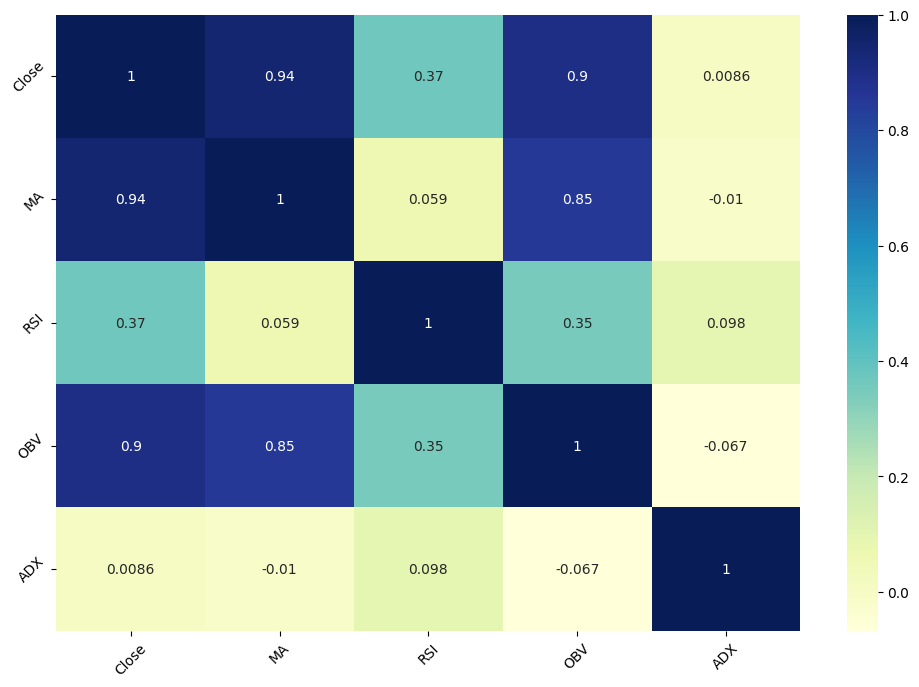

In [232]:
# Calculate the correlation matrix
correlation_matrix = indicators.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [233]:
indicators['12'] = 0.059
indicators['13'] = 0.85
indicators['14'] = -0.01
indicators['23'] = 0.35
indicators['24'] = 0.098
indicators['34'] = -0.067
indicators['dd'] = 1

In [234]:
# Actual Long or Short
data1['Actual'] = [0]*len(data1)
for i in range(1, len(data1)):
    if data1['Close'][i-1] < data1['Close'][i]:
        data1['Actual'][i] = 1
    elif data1['Close'][i-1] > data1['Close'][i]:
        data1['Actual'][i] = -1
    else:
        data1['Actual'][i] = 0

stock_data1['Actual'] = list(data1['Actual'])

In [235]:
# MA
dataset = pd.DataFrame()
ma_pred = []
for i in range(len(stock_data1)):
    if(stock_data1['MA'][i] >= stock_data1['Close'][i]):
        ma_pred.append(-1)
    else:
        ma_pred.append(1)
stock_data1['MA_pred'] = ma_pred
dataset['MA_pred'] = stock_data1['MA_pred']

# RSI
rsi_pred = []
for i in range(len(stock_data1)):
    if(stock_data1['RSI'][i] >= 50):
        rsi_pred.append(1)  # Predict bullish if RSI is greater than 50
    else:
        rsi_pred.append(-1) # Predict bullish if RSI is less than 50
stock_data1['RSI_pred'] = rsi_pred

# OBV
obv_pred = []
for i in range(1, len(stock_data1)):
    if stock_data1['OBV'][i] > stock_data1['OBV'][i-1]:
        obv_pred.append(1)  # Predict bullish if OBV is increasing
    else:
        obv_pred.append(-1)  # Predict bearish if OBV is decreasing or staying the same
obv_pred.insert(0, 0)
stock_data1['OBV_pred'] = obv_pred

# ADX
adx_pred = []
for i in range(1, len(stock_data1)):
    if stock_data1['ADX'][i] > 25:
        adx_pred.append(1)  # Predict bullish if ADX is high (indicating a strong trend)
    else:
        adx_pred.append(-1)  # Predict bearish if ADX is not high (indicating a weak or no clear trend)
adx_pred.insert(0, 0)
stock_data1['ADX_pred'] = adx_pred

In [236]:
def func(A, b):
  # To avoid singularity
  small_value = 1e-2
  ATA = A.T @ A + small_value * np.identity(A.shape[1])
  ATA_inverse = np.linalg.inv(ATA)
  ATA = ATA_inverse @ A.T
  w = ATA @ b
  return w[1:5]

temp = np.array(indicators.iloc[:,1:])
stock_data1['Method-3'] = 0
for i in range(30,len(stock_data1)):
  A = temp[i-5:i]
  b = np.array(stock_data1['Actual'].iloc[i-5:i])
  weights = func(A,b)
  sum1 = np.sum(weights)
  indicator_values = stock_data1.iloc[i, [11,12,13,14]]
  ans = (
      weights[0]/sum1 * indicator_values['MA_pred'] +
      weights[1]/sum1 * indicator_values['RSI_pred'] +
      weights[2]/sum1 * indicator_values['OBV_pred'] +
      weights[3]/sum1 * indicator_values['ADX_pred']
  )

  # threshold = 0
  # if ans >= threshold it is considered as bullish
  # else bearish
  if ans >= 0:
      stock_data1['Method-3'][i] = 1
  else:
      stock_data1['Method-3'][i] = -1

# Shift 1 above because at ith timestamp we are supposed to (i+1)th timestamp
stock_data1['Method-3'] = stock_data1['Method-3'].shift(-1)

# For next day (end of dataset)
A = temp[len(stock_data1)-5:len(stock_data1)]
b = np.array(stock_data1['Actual'].iloc[len(stock_data1)-5:len(stock_data1)])
weights = func(A,b)
sum1 = np.sum(weights)
indicator_values = stock_data1.iloc[len(stock_data1)-1, [11,12,13,14]]
ans = (
    weights[0]/sum1 * indicator_values['MA_pred'] +
    weights[1]/sum1 * indicator_values['RSI_pred'] +
    weights[2]/sum1 * indicator_values['OBV_pred'] +
    weights[3]/sum1 * indicator_values['ADX_pred']
)

# threshold = 0
# if ans >= threshold it is considered as bullish
# else bearish
if ans >= 0:
    stock_data1['Method-3'][len(stock_data1)-1] = 1
else:
    stock_data1['Method-3'][len(stock_data1)-1] = -1

In [237]:
# Accuracy calculation
def accuracy(column):
    global stock_data1
    acc = 0
    for i in range(30,len(stock_data1)-1):
        if stock_data1['Actual'][i+1] == stock_data1[column][i]:
            acc+=1
    return acc/(len(stock_data1)-30)

res = accuracy('Method-3')
print(f"Accuracy of prediction is {res * 100:.4f} %")

Accuracy of prediction is 92.3928 %


# To CSV

In [238]:
stock_data['Combined_pred'][stock_data['Combined_pred'] == 1] = 'L'
stock_data['Combined_pred'][stock_data['Combined_pred'] == -1] = 'S'
# First 30 datas are used in moving average so there is possibility that Prediction may have 0 in first 30 datas so denoting them as 'X'
# Don't consider 1st 30.
stock_data['Combined_pred'][stock_data['Combined_pred'] == 0] = 'X'

In [239]:
stock_data['Combine_predic'][stock_data['Combine_predic'] == 1] = 'L'
stock_data['Combine_predic'][stock_data['Combine_predic'] == -1] = 'S'
# First 30 datas are used in moving average so there is possibility that Prediction may have 0 in first 30 datas so denoting them as 'X'
# Don't consider 1st 30.
stock_data['Combine_predic'][stock_data['Combine_predic'] == 0] = 'X'

In [240]:
stock_data['Method-3'] = list(stock_data1['Method-3'])
stock_data['Method-3'][stock_data['Method-3'] == 1] = 'L'
stock_data['Method-3'][stock_data['Method-3'] == -1] = 'S'
# First 30 data are used in moving average so there is possibility that Prediction may have 0 in first 30 datas so denoting them as 'X'
# Don't consider 1st 30.
stock_data['Method-3'][stock_data['Method-3'] == 0] = 'X'

In [241]:
# To CSV
final_data = stock_data[['Close', 'Combined_pred', 'Combine_predic', 'Method-3']].iloc[30:]
final_data.columns = ['Close', 'Method-1', 'Method-2', 'Method-3']
final_data.to_csv("Prediction.csv")